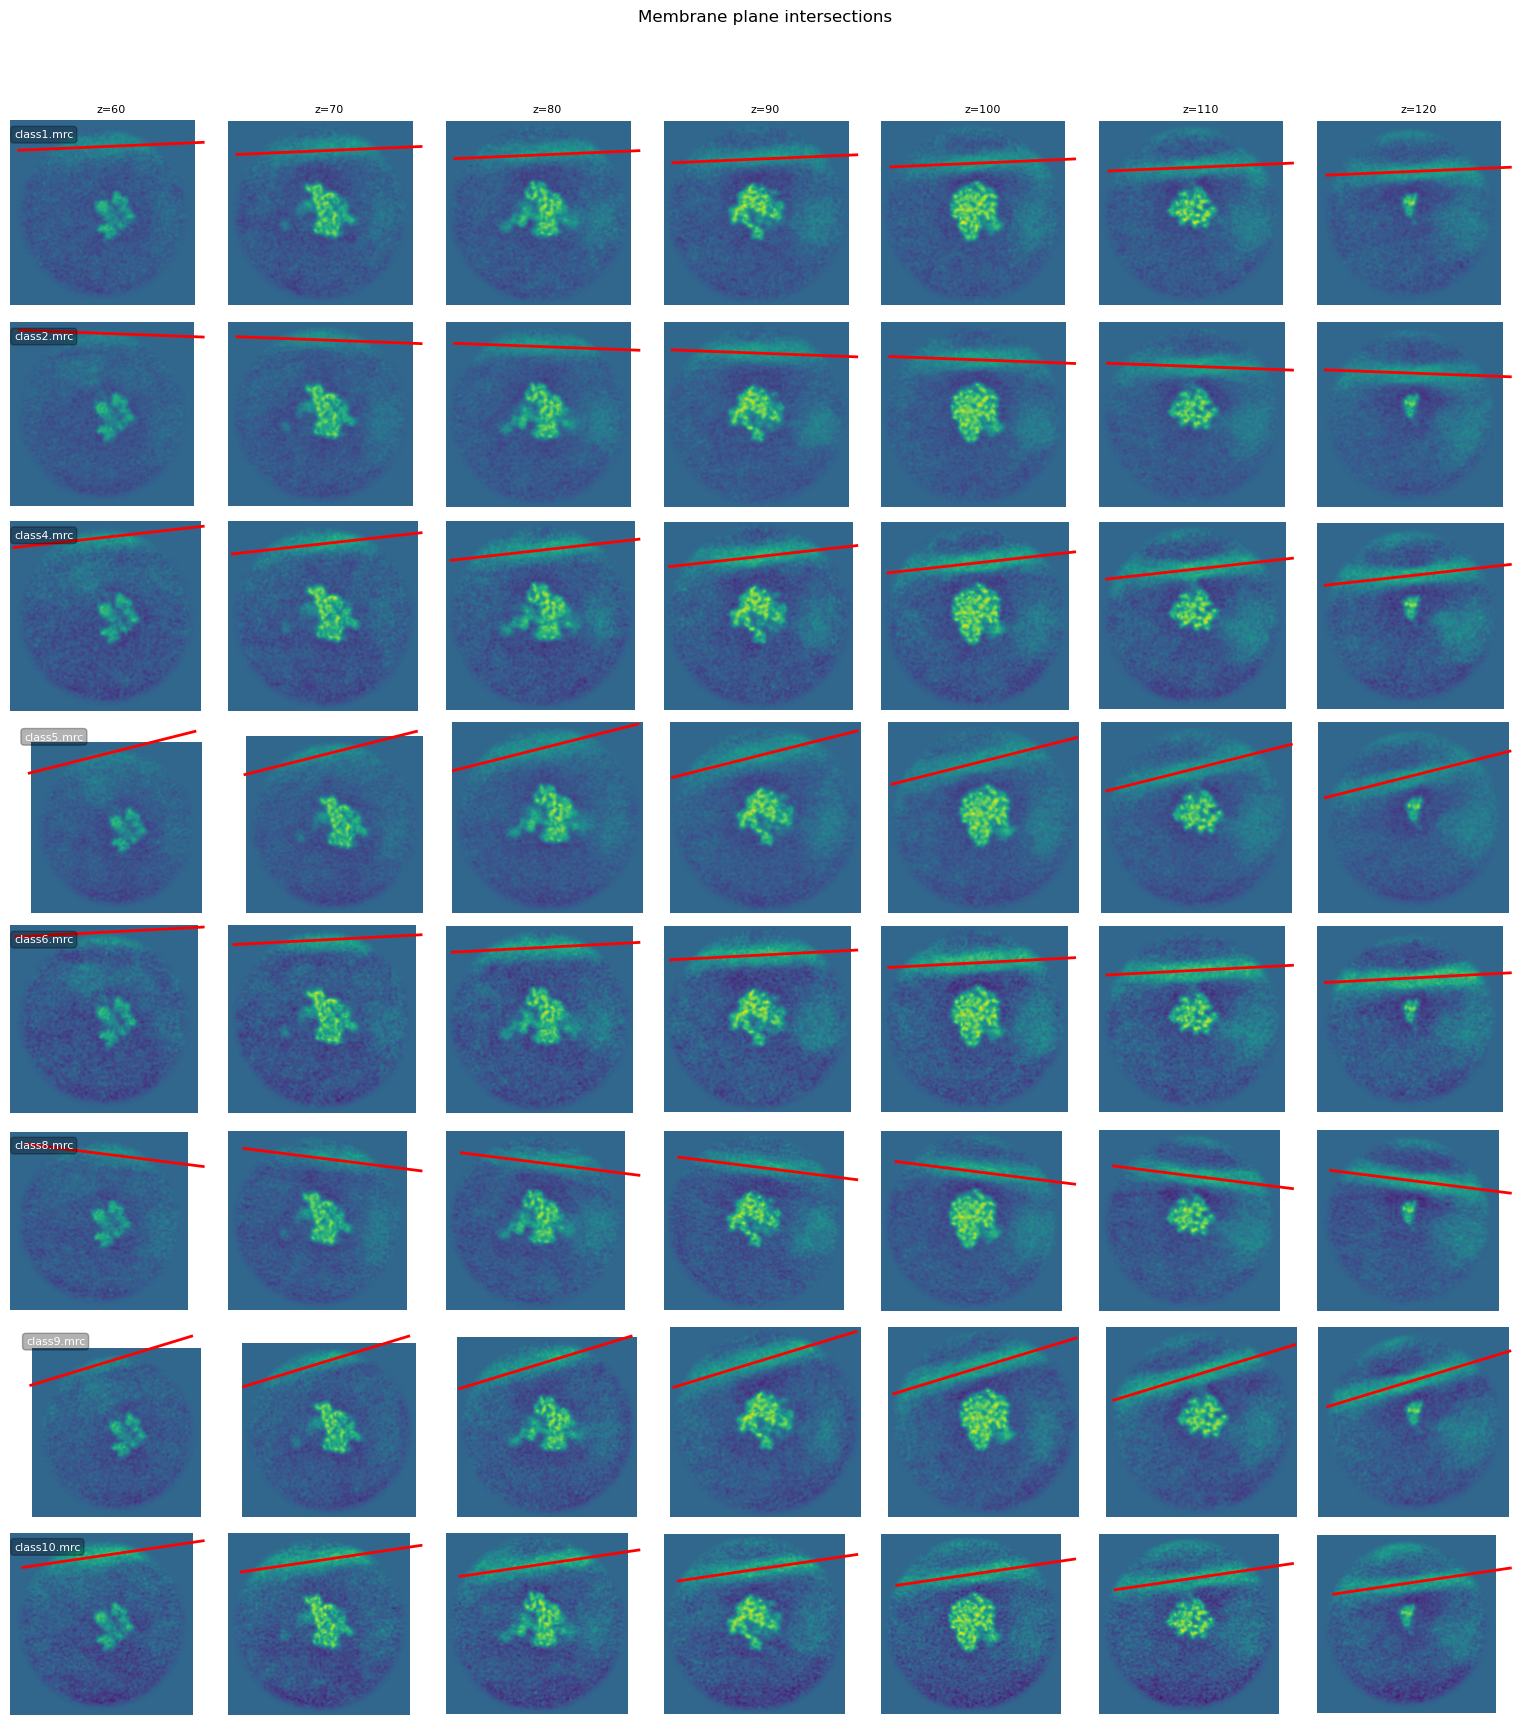

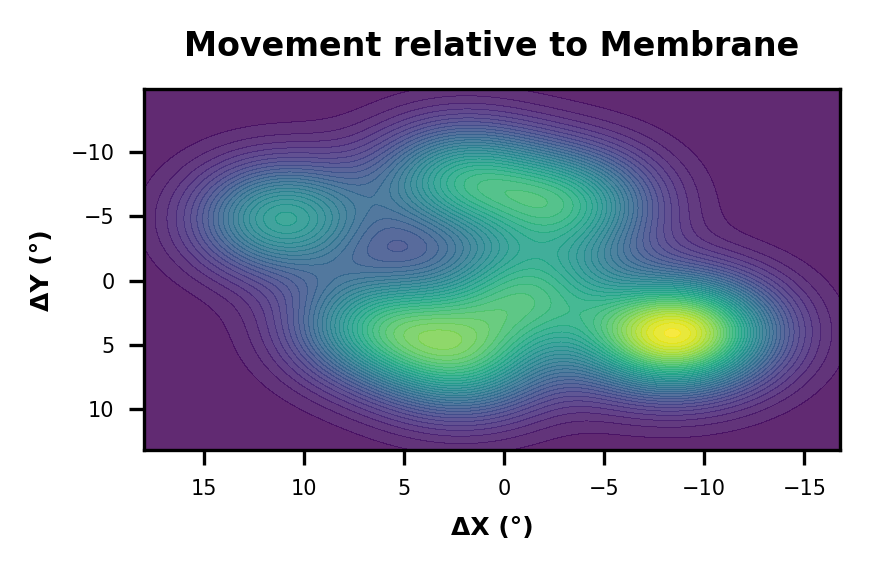

In [ ]:
#!/usr/bin/env python3
import os, glob
import numpy as np
import mrcfile
import matplotlib.pyplot as plt

# === Parameters ===
HIGH_PCT = 98        # Percentile threshold for membrane detection
R_INNER = 0.25       # Inner radius of annular search region (fraction of max)
R_OUTER = 0.85       # Outer radius of annular search region
Z_HALF_RANGE = 30    # Z-slices to sample around membrane center

def class_key(fname):
    """Extract class number from filename for sorting."""
    base = os.path.splitext(fname)[0]
    return int(base.split("class")[-1])

def annulus_mask_2d(shape, center, r_in, r_out):
    """Create annular mask between r_in and r_out (as fractions of max radius)."""
    h, w = shape
    cy, cx = center
    Y, X = np.meshgrid(np.arange(h), np.arange(w), indexing="ij")
    R = np.sqrt((Y - cy)**2 + (X - cx)**2)
    r_max = R.max()
    return (R > r_in * r_max) & (R < r_out * r_max)

def pca_line_2d(coords):
    """Fit principal axis through 2D coordinates."""
    m = coords.mean(axis=0)
    c = coords - m
    cov = c.T @ c
    eigvals, eigvecs = np.linalg.eigh(cov)
    d = eigvecs[:, np.argmax(eigvals)]
    return m, d / np.linalg.norm(d)

def fit_membrane_xy(vol):
    """Find membrane center slice and extract 2D orientation."""
    z_profile = vol.mean(axis=(1, 2))
    z_mem = int(np.argmax(z_profile))
    img = vol[z_mem].astype(np.float32)
    h, w = img.shape
    ann = annulus_mask_2d(img.shape, (h/2, w/2), R_INNER, R_OUTER)
    vals = img[ann]
    thr = np.percentile(vals, HIGH_PCT)
    mem_mask = (img >= thr) & ann
    coords = np.column_stack(np.nonzero(mem_mask))
    m, d = pca_line_2d(coords)
    return z_mem, m, d, ann

def fit_membrane_stack(vol):
    """Extract 3D membrane normal from volume stack."""
    zdim = vol.shape[0]
    z_mem, m, d, ann = fit_membrane_xy(vol)
    
    # Get in-plane normal (perpendicular to principal axis)
    n2 = np.array([-d[1], d[0]], dtype=float)
    n2 /= np.linalg.norm(n2)

    # Track membrane tilt across Z-slices
    z_low = max(0, z_mem - Z_HALF_RANGE)
    z_high = min(zdim - 1, z_mem + Z_HALF_RANGE)
    z_vals, c_vals = [], []

    for z in range(z_low, z_high + 1):
        img = vol[z].astype(np.float32)
        vals = img[ann]
        thr = np.percentile(vals, HIGH_PCT)
        mem_mask = (img >= thr) & ann
        coords = np.column_stack(np.nonzero(mem_mask))
        if coords.shape[0] < 30:
            continue
        proj = coords @ n2
        c_vals.append(proj.mean())
        z_vals.append(z)

    # Linear fit gives Z-component of tilt
    if len(z_vals) >= 2:
        a, b = np.polyfit(z_vals, c_vals, 1)
    else:
        a = 0.0
        b = float(np.dot(m, n2))

    c_ref = float(np.dot(m, n2))
    
    # Construct 3D normal (Z, Y, X order in volume coordinates)
    N_zyx = np.array([-a, n2[0], n2[1]], dtype=float)
    N_zyx /= np.linalg.norm(N_zyx)
    if N_zyx[0] < 0:
        N_zyx = -N_zyx
    
    # Return as (X, Y, Z) for consistency
    normal3d = np.array([N_zyx[2], N_zyx[1], N_zyx[0]], dtype=float)

    return dict(z_mem=z_mem, mean=m, direction=d, normal2d=n2,
                a=a, b=b, c_ref=c_ref, normal3d=normal3d)

def draw_line(ax, m, d, shape, color="r", lw=2, frac=0.5):
    """Draw a line through point m in direction d."""
    h, w = shape
    L = frac * min(h, w)
    t = np.array([-L, L])
    y = m[0] + d[0] * t
    x = m[1] + d[1] * t
    ax.plot(x, y, color=color, linewidth=lw)

def project_normals(normals):
    """Project 3D normals onto tangent plane of mean normal."""
    n0 = normals.mean(axis=0)
    n0 /= np.linalg.norm(n0)
    
    # Build orthonormal basis in tangent plane
    tmp = np.array([1.0, 0.0, 0.0]) if abs(np.dot(n0, [1,0,0])) < 0.9 else np.array([0.0, 1.0, 0.0])
    t1 = tmp - np.dot(tmp, n0) * n0
    t1 /= np.linalg.norm(t1)
    t2 = np.cross(n0, t1)
    t2 /= np.linalg.norm(t2)

    # Project each normal onto tangent plane
    coords = []
    theta_deg = []
    for n in normals:
        cos_th = np.clip(np.dot(n0, n), -1.0, 1.0)
        th = np.arccos(cos_th)
        if th < 1e-8:
            u = t1
        else:
            u = (n - cos_th * n0) / np.sin(th)
            u /= np.linalg.norm(u)
        th_deg = np.degrees(th)
        theta_deg.append(th_deg)
        x = th_deg * np.dot(u, t1)
        y = th_deg * np.dot(u, t2)
        coords.append((x, y))
    return np.array(coords), np.array(theta_deg), n0

def max_pairwise_angle(normals):
    """Calculate maximum pairwise angle between normals."""
    A = normals @ normals.T
    A = np.clip(A, -1.0, 1.0)
    ang = np.degrees(np.arccos(A))
    iu = np.triu_indices_from(ang, k=1)
    return ang[iu].max()

# === Main Analysis ===
base_dir = "path/to/membrane_classes/"
mrc_paths = sorted(
    p for p in glob.glob(os.path.join(base_dir, "Membrane_class*.mrc"))
    if "_not" not in os.path.basename(p)
)

# Extract membrane normals and store all results
results = {}
for path in mrc_paths:
    name = os.path.basename(path)
    with mrcfile.open(path, permissive=True) as mrc:
        vol = mrc.data.astype(np.float32)
    res = fit_membrane_stack(vol)
    res["vol"] = vol
    results[name] = res

# Sort class names
names = sorted(results.keys(), key=class_key)

# Get global intensity range for consistent visualization
vmin = min(results[n]["vol"].min() for n in names)
vmax = max(results[n]["vol"].max() for n in names)

# === PLOT 1: Membrane plane intersections across Z-slices ===
z_start, z_end, num_slices = 60, 120, 7
z_indices = np.linspace(z_start, z_end, num_slices, dtype=int)
nrows, ncols = len(names), len(z_indices)

fig, axes = plt.subplots(nrows, ncols,
                         figsize=(2.2 * ncols, 2.2 * nrows),
                         squeeze=False)

for i, name in enumerate(names):
    r = results[name]
    vol = r["vol"]
    d2 = r["direction"]
    n2 = r["normal2d"]
    a, b, m_ref, c_ref = r["a"], r["b"], r["mean"], r["c_ref"]
    
    for j, z in enumerate(z_indices):
        ax = axes[i, j]
        zc = int(np.clip(z, 0, vol.shape[0] - 1))
        img = vol[zc]
        
        # Calculate membrane position at this Z
        c_z = a * zc + b
        t_shift = c_z - c_ref
        m_z = m_ref + t_shift * n2
        
        ax.imshow(img, cmap="viridis", vmin=vmin, vmax=vmax)
        draw_line(ax, m_z, d2, img.shape, color="r", lw=2, frac=0.5)
        ax.axis("off")
        
        if i == 0:
            ax.set_title(f"z={zc}", fontsize=8)
        if j == 0:
            ax.text(0.02, 0.95, name.replace("Membrane_", ""),
                    transform=ax.transAxes,
                    fontsize=8, color="white",
                    va="top", ha="left",
                    bbox=dict(boxstyle="round",
                              facecolor="black", alpha=0.3))

plt.suptitle("Membrane plane intersections", fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("membrane_plane_intersections.png", dpi=300, bbox_inches="tight")
plt.show()


# === PLOT 2: Angular deviation density map ===
normals_xyz = np.array([results[n]["normal3d"] for n in names])

# Calculate statistics
coords, theta_deg, n0 = project_normals(normals_xyz)
dx_deg = coords[:, 0]
dy_deg = coords[:, 1]

# Gaussian kernel density visualization
sigma = 3
margin = 7
x_min, x_max = dx_deg.min() - margin, dx_deg.max() + margin
y_min, y_max = dy_deg.min() - margin, dy_deg.max() + margin

X, Y = np.meshgrid(np.linspace(x_min, x_max, 400), np.linspace(y_min, y_max, 200))
Z = sum(np.exp(-((X - px)**2 + (Y - py)**2) / (2 * sigma**2)) for px, py in coords)

fig, ax = plt.subplots(figsize=(3, 2), dpi=300)
ax.contourf(X, Y, Z, levels=40, alpha=0.85, cmap="viridis")
ax.set_xlabel("ΔX (°)", fontweight="bold", fontsize=6)
ax.set_ylabel("ΔY (°)", fontweight="bold", fontsize=6)
ax.set_title("Movement relative to Membrane", fontweight="bold", fontsize=8, pad=8)
ax.tick_params(labelsize=5)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.invert_xaxis()
ax.invert_yaxis()
ax.set_aspect("auto")
plt.tight_layout()
plt.savefig("movement_density_map.png", dpi=300, bbox_inches="tight")
plt.show()